# COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization 

## Implementation

#### Authors:
1. Yinghua Zhou | SID: 530833345 | UniKey: yzho0423
2.
3.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import mean_squared_error
import warnings

warnings.simplefilter('ignore')

## 1. Load Dataset

### Load ORL Dataset and Extended YaleB Dataset. (Description from the assignment suplementary ipynb file)
- ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 46x56 pixels.


- Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [2]:
def load_data(root, reduce):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.

    Acknowledgement: This function is completely from the assignment 1 instruction ipynb file of COMP4328/5328
    Advanced Machine Learning course at University of Sydney. For the purpose of loading data only.
    """
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L')  # grey image.

            # reduce computation complexity.
            img = img.resize([s // reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1, 1))

            # collect data and label.
            images.append(img / 255.0)  # normalize to [0, 1], easier to work with for many algorithms.
            labels.append(i)

    # concat all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

##### Load the YaleB dataset:

In [3]:
# reduce_ = 4

# # Load Extended YaleB dataset.
# X_hat, Y_hat = load_data(root='../data/CroppedYaleB', reduce=reduce_)
# print('Extended YaleB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
# img_size = [i // reduce_ for i in (168, 192)]

##### Load the ORL dataset (Please uncomment when working on the YaleB dataset)

In [4]:
reduce_ = 3

# Load ORL dataset.
X_hat, Y_hat = load_data(root='../data/ORL', reduce=reduce_)
print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
img_size = [i // reduce_ for i in (92, 112)]

ORL dataset: X_hat.shape = (1110, 400), Y_hat.shape = (400,)


##### Definition of some globally consistent hyper-parameters

In [5]:
global_n_components = 80 if img_size[1] == 2414 else 40  # Number of dictionary components
global_max_step = 1000 if img_size[1] == 2414 else 500 # Maximum step size (training loop)

##  2. Noise Adder Functions

In [6]:
def add_gaussian_noise(img, mean=0, sd=0.05):
    """
     In a sense, the standard deviation in gaussian noise can be thought of
     as the degree of noise, and mean as the standard noise.

    :param img: Original image.
    :param mean: Mean of the gaussian noise.
    :param sd: Standard deviation of the gaussian noise.
    :return: Noisy image.
    """
    noise = np.random.normal(mean, sd, img.shape)

    return np.clip(img + noise, 0, 1)

In [7]:
def add_salt_pepper_noise(img, noise_prob=0.3, salt_prob=0.5):
    """
    Add salt and pepper noise to the image.
    :param img: Original image.
    :param noise_prob: Probability of the noise.
    :param salt_prob: Probability of the salt noise. Pepper noise is 1 - salt_prob.
    :return: Noisy image.
    """
    # Create a mask for the pixels that will have noise
    noise_mask = np.random.rand(*img.shape) < noise_prob

    # Create a mask for salt (within the previously chosen noise pixels)
    salt_mask = np.random.rand(*img.shape) < salt_prob

    # Copy the original image
    noisy_img = img.copy()

    # Apply salt and pepper noise using the masks
    noisy_img[noise_mask & salt_mask] = 1  # apply salt noise
    noisy_img[noise_mask & ~salt_mask] = 0  # apply pepper noise

    return noisy_img

In [8]:
def add_block_occlusion_noise(img, img_size, width=0.3, height=0.3):
    assert width < 1, "width needs to be less than 1"
    assert height < 1, "height needs to be less than 1"
    
    img_copy = img.copy()
    
    num_samples = img_copy.shape[1]
    
    img_copy = img_copy.T.reshape(num_samples, img_size[1], img_size[0])
    
    block_height = int(img_size[1] * height)
    block_width = int(img_size[0] * width)
    
    for i in range(num_samples):
        start_x = np.random.randint(0, img_size[0] - block_width)
        start_y = np.random.randint(0, img_size[1] - block_height)
        
        img_copy[i, start_y:start_y+block_height, start_x:start_x+block_width] = 1  # Set to white
    
    return img_copy.reshape(num_samples, img_size[0] * img_size[1]).T

In [9]:
# # Randomly sample a subset of images from the dataset
# n_samples = 100#int(X_hat.shape[1] * train_size_ratio)
# sample_idx = np.random.choice(X_hat.shape[1], n_samples, replace=False) # Randomly pick samples
# X_hat = X_hat[:, sample_idx] # Sampled matrix
# Y_hat = Y_hat[sample_idx]

##### Select the noise type: 0 for Gaussian, 1 for salt-pepper, 2 for block occlusion

In [10]:
# 0 for Gaussian, 1 for salt-pepper, 2 for block occlusion
n_id = 3

if n_id == 1:
    X_noise = add_gaussian_noise(X_hat, sd=0.1)
elif n_id == 2:
    X_noise = add_salt_pepper_noise(X_hat, noise_prob=0.15, salt_prob=0.5)
else:
    X_noise = add_block_occlusion_noise(X_hat, img_size, width=0.3, height=0.3)

##### Example of the applied noise. (Image displayed in randomly chosen)

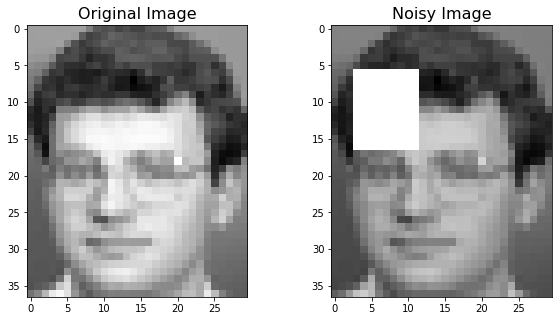

In [11]:
noise_demo_img_index = np.random.randint(0, X_noise.shape[1])

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Original Image", fontsize=16)
plt.imshow(X_hat[:,noise_demo_img_index].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(122)
plt.title("Noisy Image", fontsize=16)
plt.imshow(X_noise[:,noise_demo_img_index].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.show()

## 3. Evaluation Metrics

##### We apply the following three metrics for our evaluation:
1. Relative Reconstruction Error (RRE):

    $RRE(V, W, H) = \frac{||V - WH||_F}{||V||_F}$
       
    Where V is the original clean data matrix, W is the dictionary matrix and H is the transformed data matrix.


2. Averaged Accuracy

    $Acc(Y, Y_{pred}) = \frac{1}{n}\sum_{i=1}^n 1\{Y_{pred(i)} == Y(i)\}$
    
    
3. Normalized Mutual Information (NMI).

    $NMI(Y, Y_{pred}) = \frac{2*I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}$
   
   Where $I(.,.)$ is mutual information and  $𝐻(⋅)$ is entropy.

In [12]:
def assign_cluster_label(X, Y):
    """
    Assign cluster labels to the transformed data matrix via KMeans clustering.
    :param X: Transformed data matrix.
    :param Y: Original labels.
    :return: Y_pred

    Acknowledgement: This function is completely from the assignment 1 instruction ipynb file of COMP4328/5328
    Advanced Machine Learning course at University of Sydney.
    """
    kmeans = KMeans(n_clusters=len(set(Y)), random_state=0).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        """for each centroid, label its instances by majority"""
        ind = kmeans.labels_ == i  # get the index of instances which labeled as i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0]  # assign label.
    return Y_pred


def calc_rre(V_clean, W, H):
    """
    Calculate the Relative Reconstruction Error (RRE) between the original data matrix and the reconstructed data matrix.
    :return: RRE
    """
    return np.linalg.norm(V_clean - W @ H, ord="fro") / np.linalg.norm(V_clean, ord="fro")


def calc_aa(Y, Y_pred):
    """Calculate the Average Accuracy (AA) between the original labels and the predicted labels."""
    return accuracy_score(Y, Y_pred)


def calc_nmi(Y, Y_pred):
    """Calculate the Normalized Mutual Information (NMI) between the original labels and the predicted labels."""
    return normalized_mutual_info_score(Y, Y_pred)


def evaluate(V_clean, W, H, Y):
    """
    Evaluate the performance of the model by calculating the following metrics:
    1. Relative Reconstruction Error (RRE)
    2. Average Accuracy
    3. Normalized Mutual Information (NMI)

    :return: RRE, AA, NMI
    """
    assert V_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
    assert W is not None, "Please provide the dictionary matrix."
    assert H is not None, "Please provide the transformed data matrix."
    assert Y is not None, "Please provide the original labels from the dataset."

    rre = calc_rre(V_clean, W, H)

    Y_pred = assign_cluster_label(H.T, Y)
    # Y_pred_ori = assign_cluster_label(V_clean.T, Y)
    
    aa = calc_aa(Y, Y_pred)
    nmi = calc_nmi(Y, Y_pred)

    return rre, aa, nmi


def plot_metrics(rre, aa, nmi, plot_interval):
    plt.figure(figsize=(15, 5))

    # Plot for Rooted Mean Squared Error
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, first plot
    plt.plot(np.array(range(len(rre))) * plot_interval, rre)
    plt.xlabel('Steps')
    plt.ylabel('Rooted Mean Squared Error')
    plt.title('Rooted Mean Squared Error')

    # Plot for Average Accuracy
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
    plt.plot(np.array(range(len(aa))) * plot_interval, aa)
    plt.xlabel('Steps')
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy')

    # Plot for Normalized Mutual Information
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
    plt.plot(np.array(range(len(nmi))) * plot_interval, nmi)
    plt.xlabel('Steps')
    plt.ylabel('Normalized Mutual Information')
    plt.title('Normalized Mutual Information')

    # Show all plots
    plt.tight_layout()
    plt.show()

## 4. NMF Algorithms

### 4.1 L2 Norm based Standard NMF (via MUR)

In [13]:
class L2NormMURNMF:
    def __init__(self, rank, random_state=0):
        """
        Initialize the L2-Norm Multiplicative Update Rule Non-Negative Matrix Factorization model.
        Hyper-parameters are defined here.

        :param rank: Rank of the dictionary matrix. Latent dimension.
        :param random_state: Random seed.
        """
        assert rank is not None and rank > 0, "Please provide a valid integer for the rank of the dictionary matrix."

        self.np_rand = np.random.RandomState(random_state)
        self.rank = rank
        self.V_clean, self.V, self.W, self.H, self.Y = None, None, None, None, None

    def init_factors(self, V):
        """
        Initialize the dictionary matrix and transformed data matrix *randomly*.

        :param V: Original data matrix.
        :return: W, H
        """
        
        self.W = np.abs(np.random.normal(loc=0, scale=1, size=(V.shape[0], self.rank)))
        self.H = np.abs(np.random.normal(loc=0, scale=1, size=(self.rank, V.shape[1])))

    def reconstruct_train(self):
        """
        Reconstruct the trained data matrix from the dictionary matrix and transformed data matrix.

        :return: approximated V
        """
        return self.W @ self.H

    def fit_transform(self, V_clean, V, Y, steps=1000, e=1e-7, d=1e-6, verbose=False, plot=False, plot_interval=50):
        """
        Perform *Multiplicative Update Rule* for Non-Negative Matrix Factorization.

        :param V_clean: Original non-contaminated data matrix.
        :param V: Original data matrix. (Contains contamination)
        :param Y: Original labels.
        :param steps: Number of iterations.
        :param e: epsilon, added to the updates avoid numerical instability
        :param d: delta, threshold for rate of change at each step
        :param verbose: True to print out the convergence information
        :param plot: True to plot the convergence curve on the three nominated metrics
        :param plot_interval: Plot the convergence curve on the metrics every plot_interval step
        :return: W, H

        Acknowledgement: This function is inspired by and has components from the corresponding function
        in the week 6 tutorial ipynb file of COMP4328/5328 Advanced Machine Learning course at University of Sydney.
        """
        assert V_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
        assert V is not None, "Please provide the original data matrix from the dataset."
        assert Y is not None, "Please provide the original labels from the dataset."

        self.init_factors(V)
        self.V_clean, self.V, self.Y = V_clean, V, Y

        rre, aa, nmi = [], [], []
        
        if verbose:
            print("Start training...")

        start = time()

        for s in range(steps):
            """Please note in the corresponding tutorial, H is updated first, then W."""
            Hu = self.H * (self.W.T @ self.V) / (self.W.T @ self.W @ self.H + e) + e  # Update H
            Wu = self.W * (self.V @ Hu.T) / (self.W @ Hu @ Hu.T + e) + e  # Update W

            d_W = np.sqrt(np.sum((Wu-self.W)**2, axis=(0, 1)))/self.W.size
            d_H = np.sqrt(np.sum((Hu-self.H)**2, axis=(0, 1)))/self.H.size

            if d_W < d and d_H < d:
                if verbose:
                    print('Converged at step {}.'.format(s))
                break

            self.W = Wu
            self.H = Hu

            if plot and s % plot_interval == 0:
                rre_, aa_, nmi_ = evaluate(self.V_clean, self.W, self.H, self.Y)
                rre.append(rre_)
                aa.append(aa_)
                nmi.append(nmi_)

                if verbose:
                    print('Step: {}, RRE: {:.4f}, AA: {:.4f}, NMI: {:.4f}'.format(s, rre_, aa_, nmi_))

        if plot:
            plot_metrics(rre, aa, nmi, plot_interval)

        if verbose:
            print('Training Time taken: {:.2f} seconds.'.format(time()-start))

        return self.W, self.H

##### Train L2 Norm based Standard NMF

Start training...
Step: 0, RRE: 0.3125, AA: 0.1725, NMI: 0.3077
Step: 50, RRE: 0.3224, AA: 0.2325, NMI: 0.3934
Step: 100, RRE: 0.3231, AA: 0.2700, NMI: 0.4382
Step: 150, RRE: 0.3214, AA: 0.2750, NMI: 0.4274
Step: 200, RRE: 0.3209, AA: 0.2925, NMI: 0.4383
Step: 250, RRE: 0.3206, AA: 0.3175, NMI: 0.4797
Step: 300, RRE: 0.3204, AA: 0.2950, NMI: 0.4679
Step: 350, RRE: 0.3203, AA: 0.2900, NMI: 0.4380
Step: 400, RRE: 0.3202, AA: 0.3100, NMI: 0.4403
Step: 450, RRE: 0.3201, AA: 0.2950, NMI: 0.4515


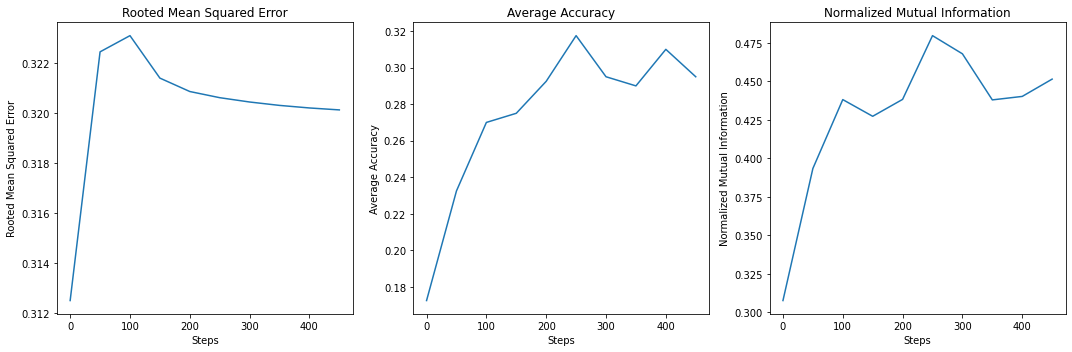

Training Time taken: 2.19 seconds.


In [14]:
model1_n_components = global_n_components

model1 = L2NormMURNMF(model1_n_components)

_, _ = model1.fit_transform(X_hat, X_noise, Y_hat, steps=global_max_step, verbose=True, plot=True)

##### Evaluate the output model using the pre-defined metrics

In [15]:
rre, aa, nmi = evaluate(X_hat, model1.W, model1.H, Y_hat)
print(f"RRE: {rre}, Average Accuracy: {aa}, NMI: {nmi}")

RRE: 0.32006016940036963, Average Accuracy: 0.2875, NMI: 0.4441261811063279


In [16]:
X_rec = model1.reconstruct_train()

##### Print out the dictionary components

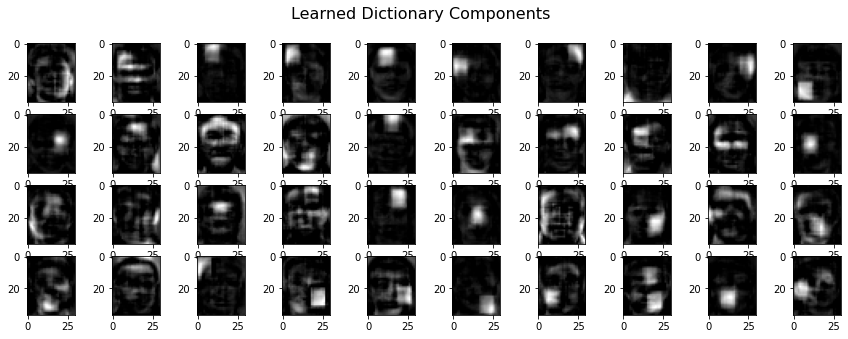

In [17]:
# Print out dictionary components

plt.figure(figsize=(15,5))

for i in range(model1_n_components // 10):
    for j in range(10):
        plt.subplot(model1_n_components // 10, 10, i * 10 + j + 1)
        plt.imshow(model1.W[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        
plt.suptitle('Learned Dictionary Components', fontsize=16)
plt.show()

##### Display the original clean image, noise applied image and the reconstructed image by Standard NMF of a randomly chosen image sample

image index:  242


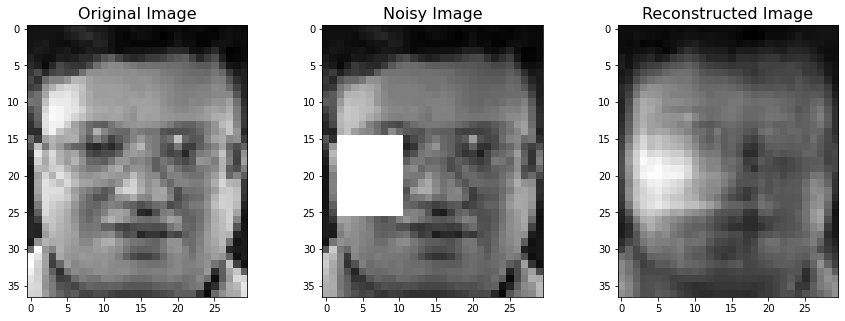

In [18]:
s = np.random.randint(0, X_hat.shape[1])
print("image index: ", s)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Original Image", fontsize=16)
plt.imshow(X_hat[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(132)
plt.title("Noisy Image", fontsize=16)
plt.imshow(X_noise[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(133)
plt.title("Reconstructed Image", fontsize=16)
plt.imshow(X_rec[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

### 4.2 Robust Nonnegative Matrix Factorization via L1 Norm Regularization (L1 Norm based Robust NMF)

In [19]:
class L1NormRobustNMF:
    def __init__(self, rank, lambda_=0.04, random_state=0):
        """
        Initialization of the Robust Non-negative Matrix Factorization via L1 Norm Regularization NMF model.
        Hyper-parameters are defined here.

        :param rank: Rank of the dictionary matrix. Latent dimension.
        :param lambda_: Regularization parameter.
        :param random_state: Random seed.
        """
        assert rank is not None and rank > 0, "Please provide a valid integer for the rank of the dictionary matrix."
        assert lambda_ is not None and lambda_ > 0, "Please provide a valid numeric for the regularization parameter."

        self.np_rand = np.random.RandomState(random_state)
        self.k = rank
        self.lambda_ = lambda_

        self.X_clean, self.X, self.W, self.H, self.E, self.Y = None, None, None, None, None, None
        self.m, self.n = None, None  # Number of features/pixels, and number of samples (rows and cols)

    def init_factors(self, X):
        """
        Initialize the dictionary matrix and transformed data matrix and
        the noise matrix *randomly* according to Normal Distribution.

        :param X: Original data matrix.
        :return: W, H, E
        """

        self.m, self.n = X.shape

        self.W = np.abs(np.random.normal(loc=0, scale=1, size=(self.m, self.k)))
        self.H = np.abs(np.random.normal(loc=0, scale=1, size=(self.k, self.n)))
        self.E = np.abs(np.random.normal(loc=0, scale=1, size=(self.m, self.n)))

        return self.W, self.H, self.E

    def reconstruct_train(self):
        """
        Reconstruct the clean data matrix from the dictionary matrix and transformed data matrix.

        :return: approximated clean data matrix.
        """
        return self.W @ self.H

    def fit_transform(self, X_clean, X, Y, steps=1000, e=1e-7, d=1e-6, verbose=False, plot=False, plot_interval=50):
        """
        Perform the model learning via the specific MURs stated in the paper.

        :param X_clean: Original non-contaminated data matrix.
        :param X: Original contaminated data matrix.
        :param Y: Original labels.
        :param steps: Number of iterations.
        :param e: epsilon, for numerical instability.
        :param d: delta, param change threshold for stopping.
        :param verbose: True to print out the convergence information.
        :param plot: True to plot the convergence curve on the three nominated metrics.
        :param plot_interval: Plot the convergence curve on the metrics every plot_interval step.
        :return: U, V, E
        """
        assert X_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
        assert X is not None, "Please provide the original data matrix from the dataset."
        assert Y is not None, "Please provide the original labels from the dataset."

        self.init_factors(X)
        self.X_clean, self.X, self.Y = X_clean, X, Y

        rre, aa, nmi = [], [], []

        if verbose:
            print("Start training...")

        start = time()

        for s in range(steps):
            X_hat = self.X - self.E
            Wu = self.W * ((X_hat @ self.H.T) / (self.W @ self.H @ self.H.T + e))

            Ep = (np.abs(self.E) + self.E) / 2
            En = (np.abs(self.E) - self.E) / 2

            V_tilde = np.vstack((self.H, np.vstack((Ep, En))))

            X_tilde = np.vstack((self.X, np.zeros(self.n)))

            I = np.eye(self.m)

            e_m = np.full((1, self.m), np.sqrt(self.lambda_) * np.exp(1))
            U_tilde = np.vstack((np.hstack((Wu, I, -I)), np.hstack((np.zeros((1, self.k)), e_m, e_m))))

            V_tilde = np.maximum(0, V_tilde - ((V_tilde * (U_tilde.T @ U_tilde @ V_tilde)) / (
                        np.abs(U_tilde.T @ U_tilde @ V_tilde) + e))
                                 + ((V_tilde * (U_tilde.T @ X_tilde)) / (np.abs(U_tilde.T @ U_tilde @ V_tilde) + e)))

            Hu = V_tilde[:self.k, :]
            Epu = V_tilde[self.k:self.k + self.m, :]
            Enu = V_tilde[self.k + self.m:, :]

            Eu = Epu - Enu  # Mathematically, this operation gives you back E

            d_W = np.sqrt(np.sum((Wu - self.W) ** 2, axis=(0, 1))) / self.W.size
            d_H = np.sqrt(np.sum((Hu - self.H) ** 2, axis=(0, 1))) / self.H.size
            d_E = np.sqrt(np.sum((Eu - self.E) ** 2, axis=(0, 1))) / self.E.size

            if d_W < d and d_H < d and d_E < d:
                if verbose:
                    print('Converged at step {}.'.format(s))
                break

            self.W = Wu
            self.H = Hu
            self.E = Eu

            if plot and s % plot_interval == 0:
                rre_, aa_, nmi_ = evaluate(self.X_clean, self.W, self.H, self.Y)
                rre.append(rre_)
                aa.append(aa_)
                nmi.append(nmi_)

                if verbose:
                    print('Step: {}, RRE: {:.4f}, AA: {:.4f}, NMI: {:.4f}'.format(s, rre_, aa_, nmi_))

        if plot:
            plot_metrics(rre, aa, nmi, plot_interval)

        if verbose:
            print('Training Time taken: {:.2f} seconds.'.format(time() - start))

        return self.W, self.H, self.E

##### Start training the L1 Norm based Robust NMF

In [ ]:
model2_n_components = global_n_components

model2 = L1NormRobustNMF(model2_n_components)

_, _, _ = model2.fit_transform(X_hat, X_noise, Y_hat, steps=global_max_step, verbose=True, plot=True)

Start training...
Step: 0, RRE: 1.5822, AA: 0.1625, NMI: 0.2911
Step: 50, RRE: 0.3118, AA: 0.1800, NMI: 0.3383
Step: 100, RRE: 16.3412, AA: 0.1600, NMI: 0.2546
Step: 150, RRE: 0.3289, AA: 0.1625, NMI: 0.2840
Step: 200, RRE: 0.3144, AA: 0.1725, NMI: 0.2901
Step: 250, RRE: 0.3230, AA: 0.1700, NMI: 0.3275
Step: 300, RRE: 0.3227, AA: 0.2000, NMI: 0.3471
Step: 350, RRE: 0.3234, AA: 0.1850, NMI: 0.3340
Step: 400, RRE: 0.3230, AA: 0.1900, NMI: 0.3551


##### Evaluate the output model using the pre-defined metrics

In [ ]:
rre, aa, nmi = evaluate(X_hat, model2.W, model2.H, Y_hat)
print(f"RRE: {rre}, Average Accuracy: {aa}, NMI: {nmi}")

In [ ]:
X_rec2 = model2.reconstruct_train()

##### Print out the dictionary components

In [ ]:
# Print out dictionary components

plt.figure(figsize=(15,5))

for i in range(model2_n_components // 10):
    for j in range(10):
        plt.subplot(model2_n_components // 10, 10, i * 10 + j + 1)
        plt.imshow(model2.W[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        
plt.suptitle('Learned Dictionary Components', fontsize=16)
plt.show()

##### Print out the first 30 learned noises from E

In [ ]:
# Print out the first 30 learned noises E

plt.figure(figsize=(15,5))

for i in range(3):
    for j in range(10):
        plt.subplot(3, 10, i * 10 + j + 1)
        plt.imshow(model2.E[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        
plt.suptitle('Learned Noise E (First 30)', fontsize=16)
plt.show()

##### Display the original clean image, noise applied image and the reconstructed image by L1-Norm Robust NMF of a randomly chosen image.

In [ ]:
s = np.random.randint(0, X_hat.shape[1])
print("image index: ", s)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Original Image", fontsize=16)
plt.imshow(X_hat[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(132)
plt.title("Noisy Image", fontsize=16)
plt.imshow(X_noise[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(133)
plt.title("Reconstructed Image", fontsize=16)
plt.imshow(X_rec2[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.show()

### 4.3 Robust nonnegative matrix factorization using L21-norm (L21 Norm based Robust NMF)

In [ ]:
class L21RobustNMF:
    def __init__(self, rank, random_state=0):
        """
        Initialization of the Robust Non-negative Matrix Factorization via L1 Norm Regularization NMF model.
        Hyper-parameters are defined here.

        :param rank: Rank of the dictionary matrix. Latent dimension.
        :param random_state: Random seed.
        """
        assert rank is not None and rank > 0, "Please provide a valid integer for the rank of the dictionary matrix."

        self.np_rand = np.random.RandomState(random_state)
        self.rank = rank

        self.X_clean, self.X, self.W, self.H, self.Y = None, None, None, None, None

    def init_factors(self, X):
        """
        Initialize the dictionary matrix and transformed data matrix *randomly*.

        :param X: Original data matrix. (Contaminated)
        :return: W, H
        """

        self.W = np.abs(np.random.normal(loc=0, scale=1, size=(X.shape[0], self.rank)))
        self.H = np.abs(np.random.normal(loc=0, scale=1, size=(self.rank, X.shape[1])))

        return self.W, self.H

    def reconstruct_train(self):
        """
        Reconstruct the clean data matrix from the dictionary matrix and transformed data matrix.

        :return: approximated clean data matrix.
        """
        return self.W @ self.H

    def fit_transform(self, X_clean, X, Y, steps=1000, e=1e-10, d=1e-6, verbose=False, plot=False, plot_interval=50):
        """
        Perform the model learning via the specific MURs stated in the paper.

        :param X_clean: Original non-contaminated data matrix.
        :param X: Original contaminated data matrix.
        :param Y: Original labels.
        :param steps: Number of iterations.
        :param e: epsilon, added to the updates avoid numerical instability.
        :param d: delta, threshold for rate of change at each step.
        :param verbose: True to print out the convergence information.
        :param plot: True to plot the convergence curve on the three nominated metrics.
        :param plot_interval: Plot the convergence curve on the metrics every plot_interval step.
        :return: W, H
        """
        assert X_clean is not None, "Please provide the original non-contaminated data matrix from the dataset."
        assert X is not None, "Please provide the original data matrix from the dataset."
        assert Y is not None, "Please provide the original labels from the dataset."

        self.init_factors(X)
        self.X_clean, self.X, self.Y = X_clean, X, Y

        rre, aa, nmi = [], [], []
        
        if verbose:
            print("Start training...")

        start = time()

        for s in range(steps):
            D = np.diag(1 / (np.sqrt(np.sum((self.X - self.W @ self.H) ** 2, axis=0)) + e))

            Wu = self.W * ((self.X @ D @ self.H.T) / (self.W @ self.H @ D @ self.H.T + e))
            Hu = self.H * ((Wu .T @ self.X @ D) / (Wu .T @ Wu  @ self.H @ D + e))

            d_W = np.sqrt(np.sum((Wu  - self.W) ** 2, axis=(0, 1))) / self.W.size
            d_H = np.sqrt(np.sum((Hu - self.H) ** 2, axis=(0, 1))) / self.H.size

            if d_W < d and d_H < d:
                if verbose:
                    print('Converged at step {}.'.format(s))
                break

            self.W = Wu
            self.H = Hu

            if plot and s % plot_interval == 0:
                rre_, aa_, nmi_ = evaluate(self.X_clean, self.W, self.H, self.Y)
                rre.append(rre_)
                aa.append(aa_)
                nmi.append(nmi_)

                if verbose:
                    print('Step: {}, RRE: {:.4f}, AA: {:.4f}, NMI: {:.4f}'.format(s, rre_, aa_, nmi_))

        if plot:
            plot_metrics(rre, aa, nmi, plot_interval)

        if verbose:
            print('Training Time taken: {:.2f} seconds.'.format(time() - start))

        return self.W, self.H

##### Start training the L21 Norm based Robust NMF

In [ ]:
model3_n_components = global_n_components

model3 = L21RobustNMF(model3_n_components)

_, _ = model3.fit_transform(X_hat, X_noise, Y_hat, steps=global_max_step, verbose=True, plot=True)

##### Evaluate the output model using the pre-defined metrics

In [ ]:
rre, aa, nmi = evaluate(X_hat, model3.W, model3.H, Y_hat)
print(f"RRE: {rre}, Average Accuracy: {aa}, NMI: {nmi}")

In [ ]:
X_rec3 = model3.reconstruct_train()

##### Print out the dictionary components

In [ ]:
# Print out dictionary components

plt.figure(figsize=(15, 5))

for i in range(model3_n_components // 10):
    for j in range(10):
        plt.subplot(model3_n_components // 10, 10, i * 10 + j + 1)
        plt.imshow(model3.W[:, i * 10 + j].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)
        
plt.suptitle('Learned Dictionary Components', fontsize=16)
plt.show()

##### Display the original clean image, noise applied image and the reconstructed image by L21 Robust NMF of a randomly chosen image sample

In [ ]:
s = np.random.randint(0, X_hat.shape[1])
print("image index: ", s)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("Original Image", fontsize=16)
plt.imshow(X_hat[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(132)
plt.title("Noisy Image", fontsize=16)
plt.imshow(X_noise[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.subplot(133)
plt.title("Reconstructed Image", fontsize=16)
plt.imshow(X_rec3[:,s].reshape(img_size[1], img_size[0]), cmap=plt.cm.gray)

plt.show()

## 5. Experiements

In [ ]:
# setups
n_experiments = 5
train_size_ratio = 0.9

In [ ]:
def run_experiments(X_clean, Y, train_size_ratio, k, steps, n_experiments, noise_strength_traversal=False, verbose=False):
    if verbose:
        print("Starting experiments...\n")
        
    if noise_strength_traversal:
        gaussian_sd_str = [0.02, 0.05, 0.07, 0.1, 0.15]
        salt_pepper_p_str = [0.05, 0.1, 0.15, 0.2, 0.25]
        block_occ_size_str = [0.1, 0.15, 0.2, 0.25, 0.3]
    else:
        gaussian_sd_str = [0.05]
        salt_pepper_p_str = [0.3]
        block_occ_size_str = [0.3]
    
    means = []  # [[means for the first noise], [...], [...]] - Will result in a 3 x 5 x 3 x 3 tensor
    stds = []  # [[standard deviations for the first noise], [...], [...]]
    
    for n in ["gaussian", "salt_pepper", "block_occ"]:
        if verbose:
            print("****************************************")
            print("Running experiments with noise: ", n)
            print("****************************************\n")
        
        n_means = []  # means under different noise
        n_stds = []  # sd under different noise
        
        if n == "gaussian":
            strengths = gaussian_sd_str
        elif n == "salt_pepper":
            strengths = salt_pepper_p_str         
        else:
            strengths = block_occ_size_str         
        
        for s in strengths:
            if verbose:
                print("^^^^^^^^^^^^^^^^^^^^^^^^^")
                print("Current strength: ", s)
                print("^^^^^^^^^^^^^^^^^^^^^^^^^\n")
            
            ns_means = [] # mean of the three NMF algorithms across number of experiements - [(RRE, AA, NMI), (...), (...)]
            ns_stds = [] # standard deviations of the three NMF algorithms across number of experiements under diff strengths
            
            for m in ["StandardL2", "L1Robust", "L21Robust"]:
                if verbose:
                    print("----------------------------------")
                    print("Current model being assessed: ", m)
                    print("----------------------------------")
                
                if m == "StandardL2":
                    model = L2NormMURNMF(k)
                elif m == "L1Robust":
                    model = L1NormRobustNMF(k)
                else:
                    model = L21RobustNMF(k)

                m_rre = []
                m_aa = []
                m_nmi = []

                for i in range(n_experiments):
                    n_samples = int(X_clean.shape[1] * train_size_ratio)
                    sample_idx = np.random.choice(X_clean.shape[1], n_samples, replace=False) # Randomly pick samples
                    X_clean_sampled = X_clean[:, sample_idx] # Sampled matrix
                    Y_sampled = Y[sample_idx]

                    if n == "gaussian":
                        X_noise = add_gaussian_noise(X_clean_sampled, sd=s)
                    elif n == "salt_pepper":
                        X_noise = add_salt_pepper_noise(X_clean_sampled, noise_prob=s)
                    else:
                        X_noise = add_block_occlusion_noise(X_clean_sampled, img_size, width=s, height=s)

                    model.fit_transform(X_clean_sampled, X_noise, Y_sampled, steps=steps)
                    rre, aa, nmi = evaluate(X_clean_sampled, model.W, model.H, Y_sampled)

                    m_rre.append(rre)
                    m_aa.append(aa)
                    m_nmi.append(nmi)

                ns_means.append((np.mean(m_rre), np.mean(m_aa), np.mean(m_nmi)))
                ns_stds.append((np.std(m_rre), np.std(m_aa), np.std(m_nmi)))
                
                if verbose:
                    print("{} experiments completed.\nMean metrics values: {}\nSD Metrics values: {}".format(n_experiments, ns_means[-1], ns_stds[-1]))
                
            n_means.append(ns_means)
            n_stds.append(ns_stds)
        
        means.append(n_means)
        stds.append(n_stds)
        
    if verbose:
        print("\nAll experiments completed. Exiting...")
    
    return means, stds

In [ ]:
reduce_ = 3

# Load ORL dataset.
X_hat, Y_hat = load_data(root='../data/ORL', reduce=reduce_)
print('ORL dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
img_size = [i // reduce_ for i in (92, 112)]

n_components = 40
max_steps = 500

results_orl = run_experiments(X_hat, Y_hat, train_size_ratio, n_components, max_steps, n_experiments, noise_strength_traversal=True, verbose=True)
results_orl

In [ ]:
reduce_ = 4

# Load Extended YaleB dataset.
X_hat, Y_hat = load_data(root='../data/CroppedYaleB', reduce=reduce_)
print('Extended YaleB dataset: X_hat.shape = {}, Y_hat.shape = {}'.format(X_hat.shape, Y_hat.shape))
img_size = [i // reduce_ for i in (168, 192)]

n_components = 80
max_steps = 1000

results_yaleb = run_experiments(X_hat, Y_hat, train_size_ratio, n_components, max_steps, n_experiments, noise_strength_traversal=True, verbose=True)
results_yaleb

In [ ]:
noise_types = ["Gaussian Noise", "Salt & Pepper Noise", "Block Occulusion Noise"]

metrics = ["RRE", "Average Accuracy", "NMI"]

nmf_models = ["Standard L2 Norm based NMF", "L1 Norm Regularized Robust NMF", "L21 Norm based Robust NMF"]

# Strengths
gaussian_sd_str = [0.02, 0.05, 0.07, 0.1, 0.15]
salt_pepper_p_str = [0.05, 0.1, 0.15, 0.2, 0.25]
block_occ_size_str = [0.1, 0.15, 0.2, 0.25, 0.3]

strengths_list = [gaussian_sd_str, salt_pepper_p_str, block_occ_size_str]

# Loop through each type of noise
for i, noise_type in enumerate(noise_types):
    strengths = strengths_list[i]
        
    plt.figure(figsize=(18, 6))
    
    for j, metric in enumerate(metrics):
        plt.subplot(1, 3, j+1)  # Create a subplot for each metric within a set
        
        for k, nmf in enumerate(nmf_models):
            y_values = results[i, :, k, j]
            plt.plot(strengths, y_values, label=f"{nmf}")
        
        # Add title and labels
        plt.title(f"{metric} for {noise_type}")
        plt.xlabel("Noise Strength")
        plt.ylabel(metric)
        
        plt.legend()
    
    plt.suptitle(f"Graphs for {noise_type}")
    plt.show()